In [1]:
import pandas as pd
from tensorflow.keras.layers import Dense,Conv2D,UpSampling2D,BatchNormalization,Activation,Concatenate,MaxPooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
import tensorflow as tf


2025-09-26 13:21:06.977910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758892867.226059      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758892867.290637      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
import tensorflow as tf

# =========================
# CONFIG
# =========================
IMG_SIZE = 224

# Dataset 1 (Supervisely)
image_dir1 = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images"
mask_dir1  = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks"

# Dataset 2 (MADS full body)
image_dir2 = "/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images"
mask_dir2  = "/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks"

# =========================
# AUGMENTATION PIPELINE
# =========================
aug_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], additional_targets={"mask": "mask"})

def augment_image_and_mask(img, mask):
    augmented = aug_transform(image=img, mask=mask)
    return augmented["image"], augmented["mask"]

# =========================
# DATA LOADER
# =========================
def load_data(img_paths, mask_paths, img_size=IMG_SIZE, augment=False):
    X, Y = [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        # Apply augmentation
        if augment:
            img, mask = augment_image_and_mask(img, mask)

        # Normalize image
        img = img.astype("float32") / 255.0

        # Normalize mask {0,255} → {0,1}
        mask = (mask > 127).astype("int32")

        X.append(img)
        Y.append(mask)

    return np.array(X), np.array(Y)[..., np.newaxis]  # (N,H,W,1)

# =========================
# AUGMENT TO TARGET FUNCTION
# =========================
def augment_to_target(X_paths, Y_paths, target_count, img_size=IMG_SIZE):
    X_augmented, Y_augmented = [], []

    current_count = len(X_paths)
    repeat_factor = target_count // current_count + 1

    print(f"Augmenting data: repeat factor = {repeat_factor}")

    for i in range(repeat_factor):
        print(f"Augmentation pass {i+1}/{repeat_factor}")
        X_tmp, Y_tmp = load_data(X_paths, Y_paths, img_size=img_size, augment=True)
        X_augmented.append(X_tmp)
        Y_augmented.append(Y_tmp)

        if len(np.concatenate(X_augmented)) >= target_count:
            break

    X_augmented = np.concatenate(X_augmented)[:target_count]
    Y_augmented = np.concatenate(Y_augmented)[:target_count]

    return X_augmented, Y_augmented

# =========================
# COLLECT FILES
# =========================
images1 = sorted([os.path.join(image_dir1, f) for f in os.listdir(image_dir1)])
masks1  = sorted([os.path.join(mask_dir1, f)  for f in os.listdir(mask_dir1)])

images2 = sorted([os.path.join(image_dir2, f) for f in os.listdir(image_dir2)])
masks2  = sorted([os.path.join(mask_dir2, f)  for f in os.listdir(mask_dir2)])

# Merge datasets
images = np.array(images1 + images2)
masks  = np.array(masks1 + masks2)

print("Total images:", len(images))
print("Total masks:", len(masks))

# =========================
# DATA SPLIT
# =========================
# Train 80% / Temp 20%
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)

# Temp → Val 10% / Test 10%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

# =========================
# LOAD + AUGMENT
# =========================
X_train, y_train = augment_to_target(X_train, y_train, target_count=6000)
X_val, y_val     = load_data(X_val, y_val, augment=False)      # no aug
X_test, y_test   = load_data(X_test, y_test, augment=False)    # no aug

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("Unique mask values:", np.unique(y_train))


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Total images: 3859
Total masks: 3859
Train size: 3087
Validation size: 386
Test size: 386
Augmenting data: repeat factor = 2
Augmentation pass 1/2


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Augmentation pass 2/2


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

X_train: (6000, 224, 224, 3) float32
y_train: (6000, 224, 224, 1) int32
Unique mask values: [0 1]


In [3]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [4]:
import types
import tensorflow as tf
from tensorflow import keras

if not hasattr(keras.utils, "generic_utils"):
    keras.utils.generic_utils = types.SimpleNamespace()
    keras.utils.generic_utils.to_list = lambda x: x if isinstance(x, list) else [x]
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"


In [5]:
import keras_hub
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)



In [6]:
import types
import tensorflow as tf

# Import keras from tf.keras for compatibility
from tensorflow import keras
import segmentation_models as sm


# Backbone
BACKBONE = "mobilenetv2"
preprocess_input = sm.get_preprocessing(BACKBONE)

# Model
model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1,
    activation="sigmoid"
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coefficient, "accuracy"])




Segmentation Models: using `tf.keras` framework.


I0000 00:00:1758893234.761834      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# =========================
# CALLBACKS
# =========================
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_Unet.h5",   # file name
    monitor="val_dice_coefficient",  # track dice
    mode="max",            # because higher dice = better
    save_best_only=True,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coefficient",
    mode="max",
    patience=5,
    restore_best_weights=True
)

# =========================
# TRAIN
# =========================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=200,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/200


I0000 00:00:1758893292.620729     106 service.cc:148] XLA service 0x7b40d80027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758893292.621696     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758893296.694318     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1758893309.095666     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758893309.292032     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/188 ━━━━━━━━━━━━━━━━━━━━ 4:15:22 82s/step - accuracy: 0.3115 - dice_coefficient: 0.3748 - loss: 0.6252

I0000 00:00:1758893329.573835     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3630 - dice_coefficient: 0.3793 - loss: 0.6207

E0000 00:00:1758893370.731054     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758893370.926580     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3635 - dice_coefficient: 0.3795 - loss: 0.6205
Epoch 1: val_dice_coefficient improved from -inf to 0.50455, saving model to best_Unet.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 152s 375ms/step - accuracy: 0.3639 - dice_coefficient: 0.3797 - loss: 0.6203 - val_accuracy: 0.6101 - val_dice_coefficient: 0.5046 - val_loss: 0.4873
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6468 - dice_coefficient: 0.4947 - loss: 0.5053
Epoch 2: val_dice_coefficient improved from 0.50455 to 0.56971, saving model to best_Unet.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 172ms/step - accuracy: 0.6471 - dice_coefficient: 0.4948 - loss: 0.5052 - val_accuracy: 0.8294 - val_dice_coefficient: 0.5697 - val_loss: 0.4214
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8141 - dice_coefficient: 0.5468 - loss: 0.4531
Epoch 3: val_dice_coefficient improved from 0.56971 to 0.60073, saving model to best_Unet.h5
188/188 ━━━━━━━━━━━━━━━━━━━━ 32

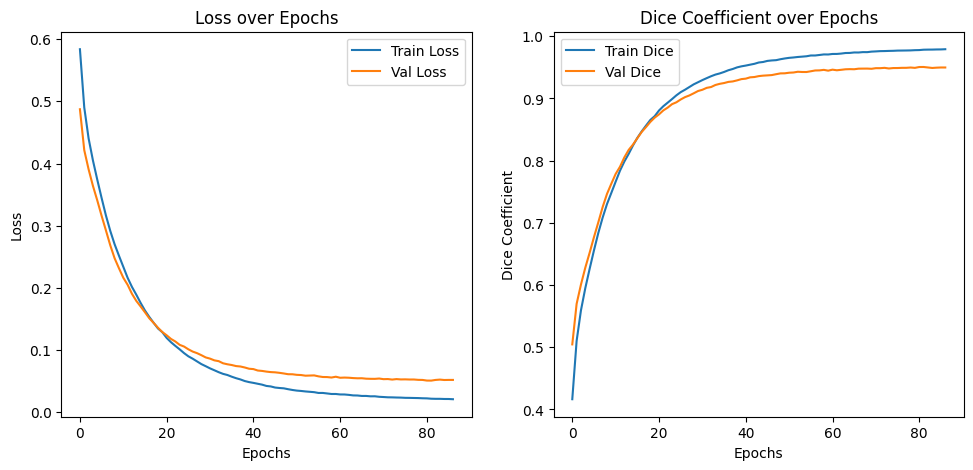

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# ----------------------
# Plot Loss
# ----------------------
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# ----------------------
# Plot Dice Coefficient
# ----------------------
plt.subplot(1, 3, 2)
plt.plot(history.history["dice_coefficient"], label="Train Dice")
plt.plot(history.history["val_dice_coefficient"], label="Val Dice")
plt.title("Dice Coefficient over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()



plt.show()


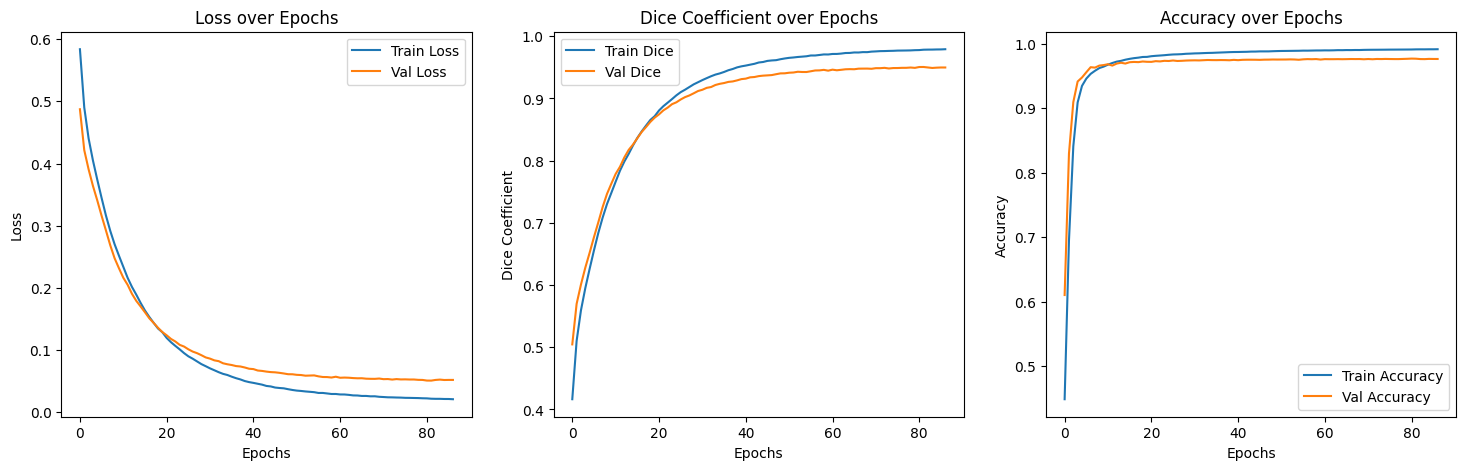

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# ----------------------
# Plot Loss
# ----------------------
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# ----------------------
# Plot Dice Coefficient
# ----------------------
plt.subplot(1, 3, 2)
plt.plot(history.history["dice_coefficient"], label="Train Dice")
plt.plot(history.history["val_dice_coefficient"], label="Val Dice")
plt.title("Dice Coefficient over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()

# ----------------------
# Plot Accuracy
# ----------------------
plt.subplot(1, 3, 3)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.9761 - dice_coefficient: 0.9488 - loss: 0.0512
Test Loss: 0.05906122177839279
Test Dice Coefficient: 0.940589964389801
Test Accuracy: 0.9728843569755554
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


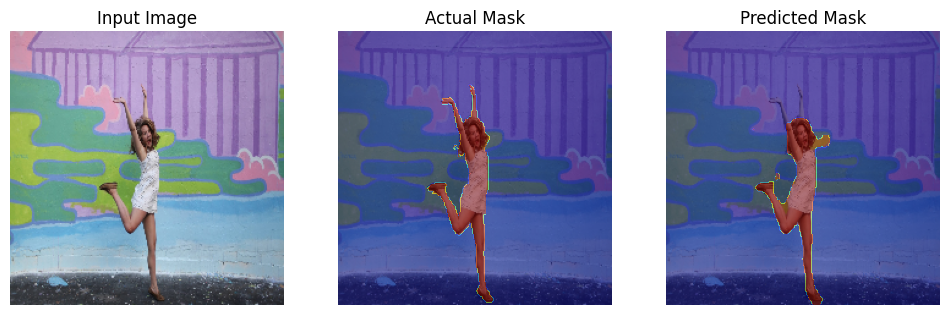

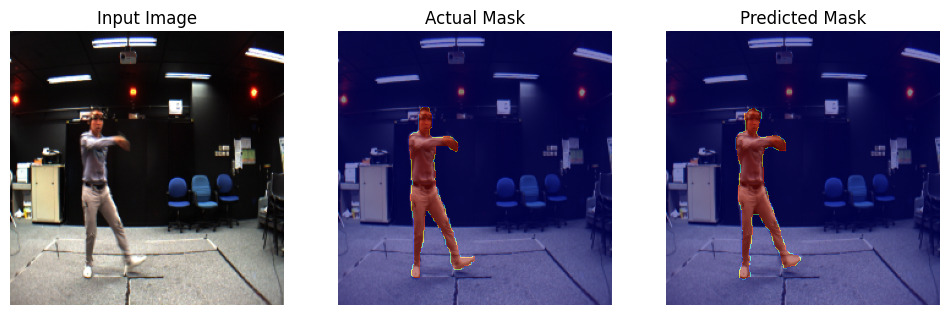

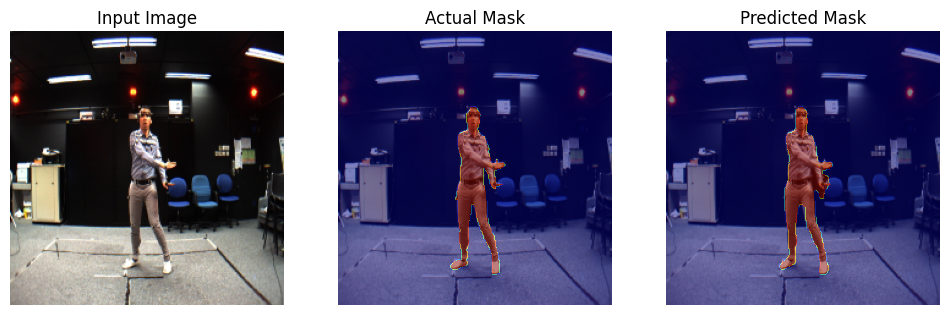

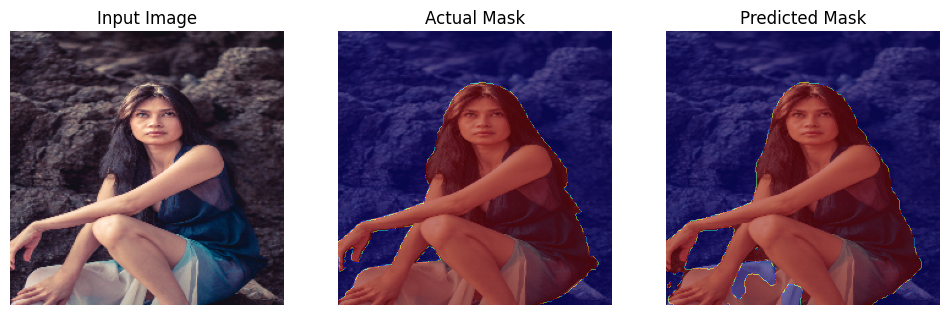

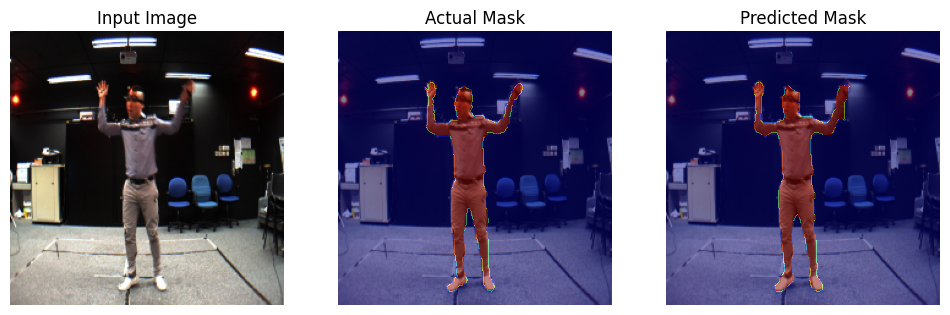

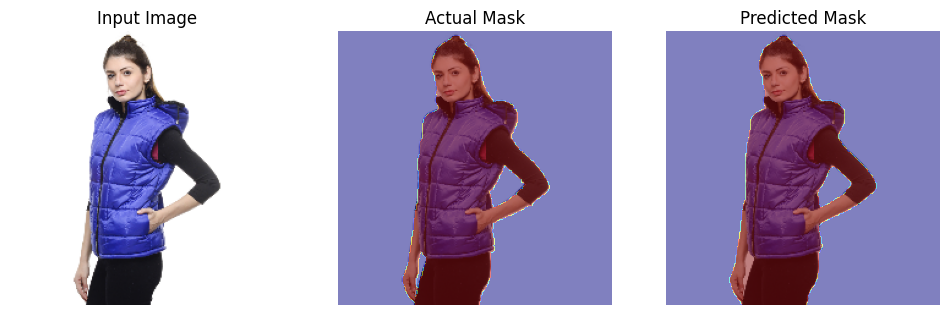

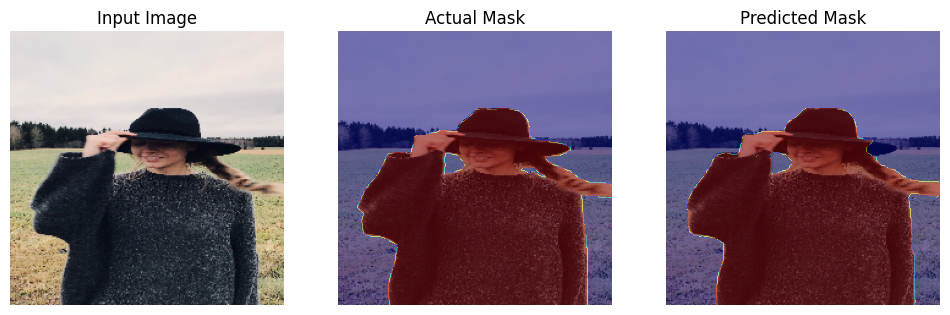

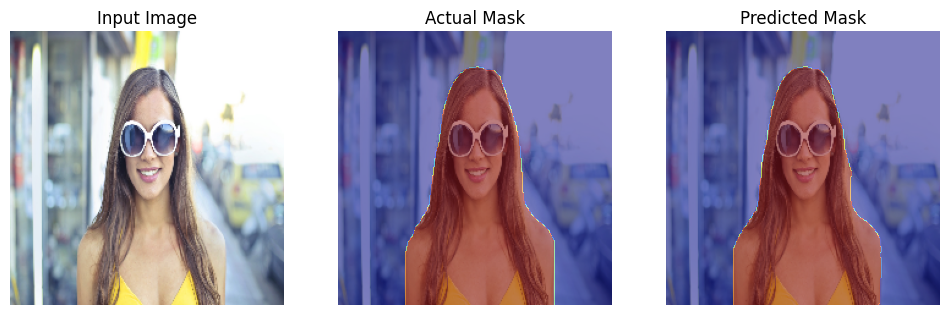

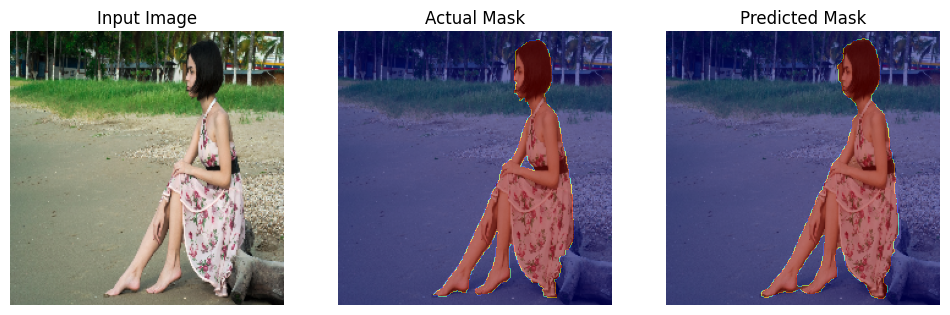

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# تحميل الموديل الأفضل
# ----------------------------
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_Unet.h5",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss
    }
)

# ----------------------------
# تجهيز بيانات الاختبار
# ----------------------------
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# ----------------------------
# تقييم على بيانات الاختبار
# ----------------------------
test_loss, test_dice, test_acc = best_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Dice Coefficient:", test_dice)
print("Test Accuracy:", test_acc)

# ----------------------------
# عرض النتائج مع ماسك ملون يشبه الشخص الطبيعي
# ----------------------------
def show_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):  # خذ batch واحد فقط
        preds = model.predict(images)
        
        # تحويل التنبؤات إلى binary mask
        preds = tf.where(preds > 0.5, 1, 0)

        for i in range(num):
            plt.figure(figsize=(12,4))

            # الصورة الأصلية
            plt.subplot(1,3,1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            # الماسك الفعلي
            plt.subplot(1,3,2)
            plt.imshow(images[i])  # عرض الشخص الطبيعي
            plt.imshow(tf.squeeze(masks[i]), cmap="jet", alpha=0.5)  # تراكب ماسك ملون
            plt.title("Actual Mask")
            plt.axis("off")

            # الماسك المتوقع
            plt.subplot(1,3,3)
            plt.imshow(images[i])  # عرض الشخص الطبيعي
            plt.imshow(tf.squeeze(preds[i]), cmap="jet", alpha=0.5)  # تراكب ماسك ملون
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.show()

# ----------------------------
# تشغيل عرض النتائج
# ----------------------------
show_predictions(test_ds, best_model, num=9)


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9761 - dice_coefficient: 0.9488 - loss: 0.0512
Test Loss: 0.05906122177839279
Test Dice Coefficient: 0.940589964389801
Test Accuracy: 0.9728843569755554


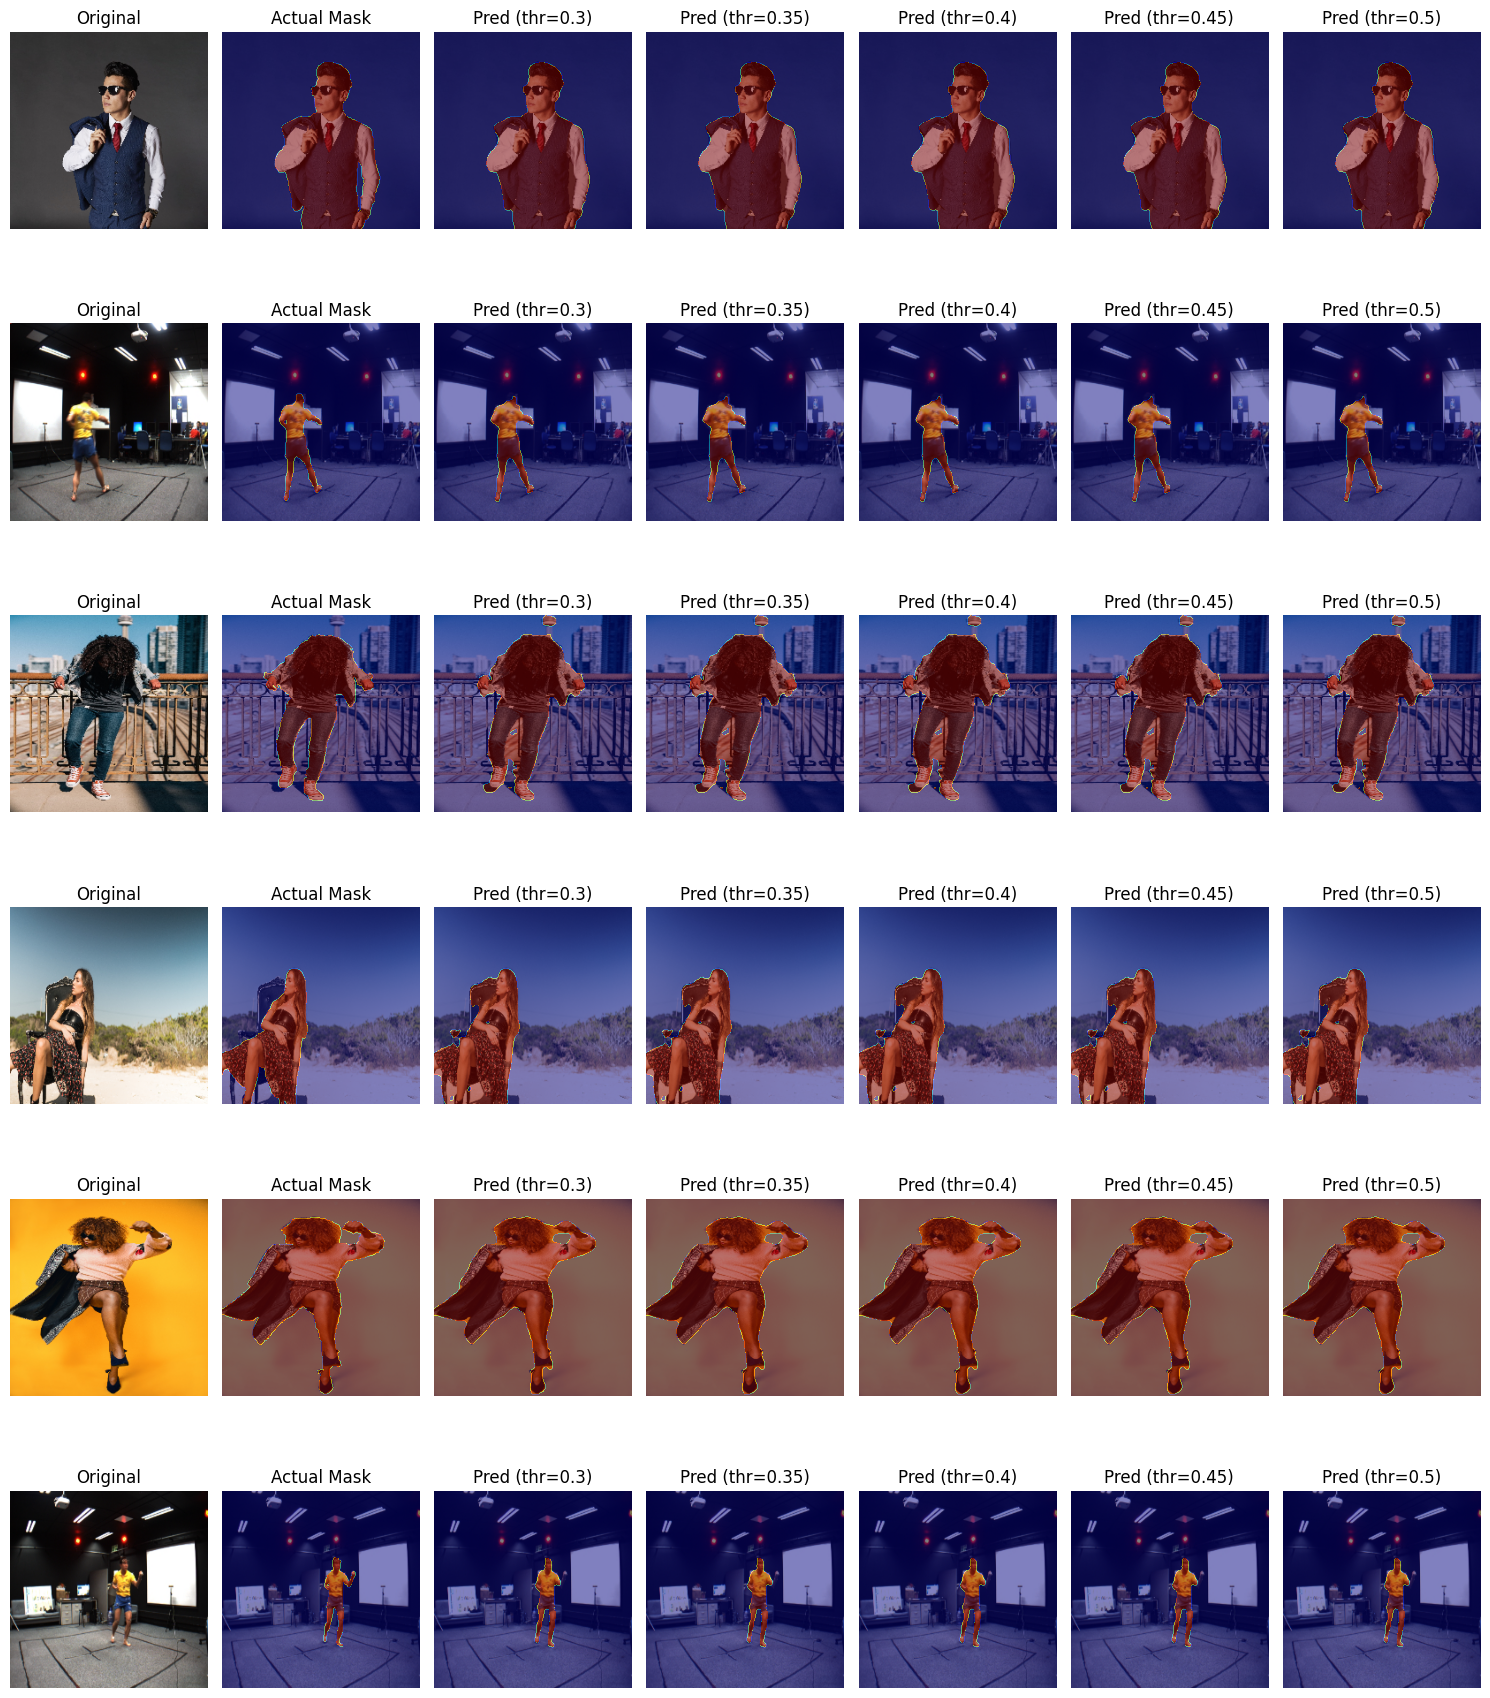

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

# ----------------------------
# تحميل الموديل الأفضل
# ----------------------------
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_Unet.h5",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "dice_loss": dice_loss
    }
)

# ----------------------------
# تجهيز بيانات الاختبار
# ----------------------------
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# ----------------------------
# تقييم على بيانات الاختبار
# ----------------------------
test_loss, test_dice, test_acc = best_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Dice Coefficient:", test_dice)
print("Test Accuracy:", test_acc)

# ----------------------------
# دالة عرض مع ثيرشولدات متعددة
# ----------------------------
def show_random_predictions(X, y, model, thresholds=[0.3,.35,.4,.45, 0.5], num=6):
    idxs = random.sample(range(len(X)), num)  # اختيار عشوائي
    plt.figure(figsize=(15, num*3))

    for i, idx in enumerate(idxs):
        image = X[idx]
        mask_true = y[idx]

        # تحويل الصورة لـ uint8 (عشان تظهر طبيعية)
        if image.max() <= 1.0:
            image_disp = (image * 255).astype("uint8")
        else:
            image_disp = image.astype("uint8")

        # prediction (soft mask)
        pred = model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]

        # ------------------ Original ------------------
        plt.subplot(num, len(thresholds) + 2, i*(len(thresholds)+2) + 1)
        plt.imshow(image_disp)
        plt.title("Original")
        plt.axis("off")

        # ------------------ Actual Mask ------------------
        plt.subplot(num, len(thresholds) + 2, i*(len(thresholds)+2) + 2)
        plt.imshow(image_disp)
        plt.imshow(tf.squeeze(mask_true), cmap="jet", alpha=0.5)
        plt.title("Actual Mask")
        plt.axis("off")

        # ------------------ Predicted Masks for thresholds ------------------
        for j, t in enumerate(thresholds):
            pred_mask = tf.where(pred > t, 1, 0)
            plt.subplot(num, len(thresholds) + 2, i*(len(thresholds)+2) + 3 + j)
            plt.imshow(image_disp)
            plt.imshow(tf.squeeze(pred_mask), cmap="jet", alpha=0.5)
            plt.title(f"Pred (thr={t})")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# ----------------------------
# تشغيل عرض النتائج
# ----------------------------
show_random_predictions(X_test, y_test, best_model, num=6)
